In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, Conv3D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import binary_crossentropy
from sklearn.metrics import f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.applications.vgg16 import preprocess_input

from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image 
import seaborn as sns
import os
import re
import glob
import cv2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
import tqdm
from numpy import loadtxt
from os import *
from sklearn.utils import class_weight


Using TensorFlow backend.


In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]

In [3]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap=plt.cm.Blues) #'viridis'
    #plt.savefig('/home/jovyan/conf_matrix.png')
    plt.show()
    
    return conf_matx

In [4]:
def plot_history(model_history, model_name):
    fig = plt.figure(figsize=(15,5), facecolor='w')
    ax = fig.add_subplot(121)
    ax.plot(model_history.history['loss'])
    ax.plot(model_history.history['val_loss'])
    ax.set(title=model_name + ': Model loss', ylabel='Loss', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    ax = fig.add_subplot(122)
    ax.plot(model_history.history['accuracy'])
    ax.plot(model_history.history['val_accuracy'])
    ax.set(title=model_name + ': Model Accuracy; test='+ str(np.round(model_history.history['val_accuracy'][-1], 3)),
           ylabel='Accuracy', xlabel='Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    #plt.savefig('/home/jovyan/curve.png')
    plt.show()
    
    return fig

In [5]:
def resize(x):
    rescaled = []

    for i in x:

        scale_percent = 140 # percent of original size
        width = int(i.shape[1] / (scale_percent / 100))
        height = int(i.shape[0] / (scale_percent / 100))
        dim = (width, height)
        resized = cv2.resize(i, dim, interpolation = cv2.INTER_LANCZOS4)
        rescaled.append(resized)

    x_orig = np.reshape( rescaled, (len( rescaled), resized.shape[1], resized.shape[1], 3))

    return x_orig

In [6]:
def loadImages(path_data):
    
    p = '/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T0_T97/'
    
    
    
    pa_adr = p + 'ADR_cropped/'
    
    pa_control = p + 'CONTROL_cropped/'
    
    pa_hrh = p + 'HRH_cropped/'
    
    image_list = []
    
    
       


    for filename in sorted(path_data, key=natural_keys): 
        
        if 'adr' in filename:
            
            im=cv2.imread(pa_adr + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)
            
        if 'control' in filename:
            
            im=cv2.imread(pa_control + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)
            
        if 'hrh' in filename:
            
            im=cv2.imread(pa_hrh + filename)

            imarray = np.array(im)
            

            image_list.append(imarray)



    x_orig = np.reshape(image_list, (len(image_list), 90, 90, 3))

    return x_orig

In [7]:
def return_count(x):
    name_wel = []
    for i in sorted(x, key = natural_keys):
        name_wel.append(i.split('_')[0])

    z = sorted(list(set(name_wel)))
    r = list(range(len(z)))

    num = []
    for iz in range(len(z)):
        count = 0
        for i in sorted(x, key=natural_keys):
            if z[iz] in i:
                count += 1
        num.append(count)
    return list(zip(z, r, num))

In [8]:
def loadImages_LSTM(path_data):
    

    feat_list = []


    for filename in sorted(glob.glob(path_data), key=natural_keys): 
        feat_list.append(np.load(filename))

    x_orig = np.reshape(feat_list, (len(feat_list),32, 64))

    return x_orig 

In [9]:
def make_labels(data_set):
    fe = return_count(data_set)
    leb = creat_label(fe)
    y = np.array(list(leb))
    return y
    

In [10]:
def make_labels_LSTM(data_set):
    fe = return_count_LSTM(data_set)
    leb = creat_label(fe)
    y = np.array(list(leb))
    return y
    

In [11]:
def return_count_LSTM(x):
    name_wel = []
    for _,_,i in os.walk(x):
        for f in i:
            name_wel.append(f.split('_')[2])

    z = sorted(list(set(name_wel)), key=natural_keys)
    r = list(range(len(z)))

    num = []
    for iz in range(len(z)):
        count = 0
        for i in sorted(name_wel, key=natural_keys):
            if z[iz] in i:
                count += 1
        num.append(count)
    return list(zip(z, r, num))

In [12]:
def creat_label(y):
    labels = []
    for ix, _ in enumerate(y):
        
        if y[ix][0] == 'adr':
        
            labels.append([[y[ix][0],0]] * y[ix][2])
        
        if y[ix][0] == 'hrh':
            
            labels.append([[y[ix][0],1]] * y[ix][2])
        
        if y[ix][0] == 'control':
            
            labels.append([[y[ix][0],1]] * y[ix][2])
    
    ler = [i for sub in labels for i in sub ]
    
    _, lab= zip(*ler)

    
    return lab

In [13]:
def time_step_acc(tes_data, x):

    results = []            

    x_test = loadImages(tes_data)
    y_test = make_labels(tes_data)
    x_test = resize(x_test)
    x_test = preprocess_input(x_test)

    scores = x.evaluate(x_test, y_test, verbose = 1)
    results.append(scores[1]*100)

    return results

In [14]:
def cv_mean_acc(result_cv, string_well):
    
    l_drug = string_well*3

    acc_mean_cv = []

    for i in result_cv:
        acc_mean_cv.append(np.mean(i))
        
    cv_drug = list(zip(acc_mean_cv, l_drug))
    
    res = sorted(cv_drug, key = lambda x: x[1])
    a , b = zip(*res)
    
    a = list(a)
    
    s = list(np.array_split(a, 5))
    
    cv_score_acc = []
    
    for ix, i in enumerate(s):
        s1 = list(s[ix])
        
        cv_score_acc.append(np.mean(s1))
        
    return list(zip(cv_score_acc, string_well))

In [15]:
# DATA FOR LSTM PART

p_feat = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/'
train_data = p_feat + 'features_train/*.npy'
val_data = p_feat + 'features_validation/*.npy'
tes_data= p_feat + 'features_test/*.npy'

y_tra_path = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/features_train/'
y_tes_path = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/features_test/'
y_val_path = '/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/features_validation/'

In [16]:
mid = ['C6', 'F11']
leb = ['D11', 'G4']
mep = ['F2', 'G10']
met = ['G5', 'B10']
oxy = ['G3', 'B8']

cyc = ['E4', 'G6']
dox = ['G8', 'D10']
olo = ['E7', 'B7']
ket = ['E10', 'B11']
orp = ['D8', 'B2']

In [17]:
tot_results_accuracy = []

results_lstm = []

In [18]:
tot_well_adr = [mid, leb, mep, met, oxy]
tot_well_hrh = [cyc, dox, olo, ket, orp]

string_well_adr = ['mid', 'leb', 'mep', 'met', 'oxy']
string_well_hrh = ['cyc', 'dox', 'olo', 'ket', 'orp']


In [19]:
tot_well = []
string_well = [] 

In [20]:
a = 'ADR' # FOR TEST SET
b = 'HRH' # FOR REST

if a == 'HRH':
    tot_well = tot_well_hrh
    string_well = string_well_hrh
    
if a == 'ADR':
    tot_well = tot_well_adr
    string_well = string_well_adr
    

In [21]:
rand = list(np.random.randint(1,1000,3))

0it [00:00, ?it/s]
100%|██████████| 2/2 [00:11<00:00,  5.88s/it]

0it [00:00, ?it/s]
10it [00:00, 81.41it/s]
15it [00:00, 66.93it/s]
19it [00:00, 54.40it/s]
23it [00:00, 45.00it/s]
27it [00:00, 41.60it/s]
32it [00:00, 43.33it/s]
38it [00:00, 44.30it/s]
43it [00:00, 44.71it/s]
48it [00:01, 39.83it/s]
52it [00:01, 39.43it/s]
57it [00:01, 40.69it/s]
62it [00:01, 35.17it/s]
66it [00:01, 35.13it/s]
72it [00:01, 42.18it/s]

100%|██████████| 72/72 [00:00<00:00, 2366.84it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500.203125 steps, validate for 127.4921875 steps
Epoch 1/300
501/500 [==============================] - 17s 35ms/step - loss: 0.6688 - accuracy: 0.5904 - val_loss: 0.6630 - val_accuracy: 0.5984
Epoch 2/300
501/500 [==============================] - 14s 27ms/step - loss: 0.6254 - accuracy: 0.6377 - val_loss: 0.6522 - val_accuracy: 0.6128
Epoch 3/300
501/500 [==============================] - 14s 27ms/step - loss: 0.6101 - accuracy: 0.6553 - val_loss: 0.6428 - val_accuracy: 0.6243
Epoch 4/300
501/500 [==============================] - 14s 27ms/step - loss: 0.5986 - accuracy: 0.6688 - val_loss: 0.6369 - val_accuracy: 0.6353
Epoch 5/300
501/500 [==============================] - 14s 27ms/step - loss: 0.5887 - accuracy: 0.6790 - val_loss: 0.6325 - val_accuracy: 0.6369
Epoch 6/300
501/500 [==============================] - 14s 27ms/step - loss: 0.5801 - accuracy: 0.6863 - val_loss: 0.6308 - val_accuracy: 0.6379
Epoch 7/300
501/500 [

1it [13:30, 810.78s/it]
100%|██████████| 2/2 [00:12<00:00,  6.06s/it]

0it [00:00, ?it/s]
8it [00:00, 72.59it/s]
11it [00:00, 47.89it/s]
15it [00:00, 44.93it/s]
18it [00:00, 38.76it/s]
23it [00:00, 40.95it/s]
27it [00:00, 34.62it/s]
32it [00:00, 35.88it/s]
38it [00:00, 38.42it/s]
43it [00:01, 40.98it/s]
48it [00:01, 38.23it/s]
52it [00:01, 37.93it/s]
57it [00:01, 39.21it/s]
61it [00:01, 32.76it/s]
66it [00:01, 33.63it/s]
72it [00:01, 38.85it/s]

100%|██████████| 72/72 [00:00<00:00, 2276.21it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 515.390625 steps, validate for 133.8671875 steps
Epoch 1/300
516/515 [==============================] - 15s 29ms/step - loss: 0.6884 - accuracy: 0.5729 - val_loss: 0.6851 - val_accuracy: 0.5768
Epoch 2/300
516/515 [==============================] - 14s 27ms/step - loss: 0.6457 - accuracy: 0.6216 - val_loss: 0.6680 - val_accuracy: 0.5996
Epoch 3/300
516/515 [==============================] - 14s 27ms/step - loss: 0.6284 - accuracy: 0.6424 - val_loss: 0.6552 - val_accuracy: 0.6194
Epoch 4/300
516/515 [==============================] - 14s 27ms/step - loss: 0.6160 - accuracy: 0.6553 - val_loss: 0.6507 - val_accuracy: 0.6216
Epoch 5/300
516/515 [==============================] - 14s 27ms/step - loss: 0.6060 - accuracy: 0.6649 - val_loss: 0.6506 - val_accuracy: 0.6224
Epoch 6/300
516/515 [==============================] - 14s 27ms/step - loss: 0.5975 - accuracy: 0.6745 - val_loss: 0.6462 - val_accuracy: 0.6310
Epoch 7/300
516/515 [

2it [26:44, 805.80s/it]
100%|██████████| 2/2 [00:12<00:00,  6.13s/it]

0it [00:00, ?it/s]
9it [00:00, 71.95it/s]
12it [00:00, 48.54it/s]
18it [00:00, 49.89it/s]
22it [00:00, 44.87it/s]
26it [00:00, 35.60it/s]
30it [00:00, 36.68it/s]
35it [00:00, 38.89it/s]
41it [00:00, 40.22it/s]
45it [00:01, 37.75it/s]
50it [00:01, 37.42it/s]
55it [00:01, 37.31it/s]
59it [00:01, 35.92it/s]
63it [00:01, 34.14it/s]
72it [00:01, 39.59it/s]

100%|██████████| 72/72 [00:00<00:00, 2006.71it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 510.46875 steps, validate for 129.9296875 steps
Epoch 1/300
511/510 [==============================] - 15s 29ms/step - loss: 0.6987 - accuracy: 0.5682 - val_loss: 0.6781 - val_accuracy: 0.5772
Epoch 2/300
511/510 [==============================] - 14s 27ms/step - loss: 0.6585 - accuracy: 0.6047 - val_loss: 0.6698 - val_accuracy: 0.5877
Epoch 3/300
511/510 [==============================] - 13s 26ms/step - loss: 0.6444 - accuracy: 0.6229 - val_loss: 0.6660 - val_accuracy: 0.5950
Epoch 4/300
511/510 [==============================] - 14s 27ms/step - loss: 0.6337 - accuracy: 0.6373 - val_loss: 0.6626 - val_accuracy: 0.6004
Epoch 5/300
511/510 [==============================] - 14s 27ms/step - loss: 0.6246 - accuracy: 0.6464 - val_loss: 0.6606 - val_accuracy: 0.6026
Epoch 6/300
511/510 [==============================] - 14s 27ms/step - loss: 0.6167 - accuracy: 0.6549 - val_loss: 0.6599 - val_accuracy: 0.6061
Epoch 7/300
511/510 [=

3it [37:00, 748.73s/it]
100%|██████████| 2/2 [00:12<00:00,  6.38s/it]

0it [00:00, ?it/s]
6it [00:00, 49.51it/s]
12it [00:00, 50.73it/s]
16it [00:00, 43.65it/s]
19it [00:00, 37.14it/s]
24it [00:00, 39.58it/s]
28it [00:00, 34.45it/s]
32it [00:00, 35.24it/s]
37it [00:00, 38.40it/s]
41it [00:01, 36.32it/s]
45it [00:01, 35.20it/s]
49it [00:01, 36.36it/s]
53it [00:01, 35.12it/s]
58it [00:01, 35.84it/s]
62it [00:01, 34.15it/s]
66it [00:01, 35.04it/s]
72it [00:01, 37.97it/s]

100%|██████████| 72/72 [00:00<00:00, 2320.79it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 517.8203125 steps, validate for 133.21875 steps
Epoch 1/300
518/517 [==============================] - 15s 29ms/step - loss: 0.6925 - accuracy: 0.5749 - val_loss: 0.6630 - val_accuracy: 0.5964
Epoch 2/300
518/517 [==============================] - 14s 27ms/step - loss: 0.6368 - accuracy: 0.6265 - val_loss: 0.6477 - val_accuracy: 0.6172
Epoch 3/300
518/517 [==============================] - 14s 27ms/step - loss: 0.6218 - accuracy: 0.6455 - val_loss: 0.6412 - val_accuracy: 0.6241
Epoch 4/300
518/517 [==============================] - 14s 27ms/step - loss: 0.6107 - accuracy: 0.6577 - val_loss: 0.6350 - val_accuracy: 0.6338
Epoch 5/300
518/517 [==============================] - 14s 27ms/step - loss: 0.6014 - accuracy: 0.6680 - val_loss: 0.6294 - val_accuracy: 0.6396
Epoch 6/300
518/517 [==============================] - 14s 27ms/step - loss: 0.5931 - accuracy: 0.6748 - val_loss: 0.6290 - val_accuracy: 0.6417
Epoch 7/300
518/517 [=

4it [52:13, 798.04s/it]
100%|██████████| 2/2 [00:13<00:00,  6.86s/it]

0it [00:00, ?it/s]
5it [00:00, 45.28it/s]
8it [00:00, 36.29it/s]
14it [00:00, 39.87it/s]
17it [00:00, 33.09it/s]
21it [00:00, 33.70it/s]
25it [00:00, 33.61it/s]
30it [00:00, 34.45it/s]
35it [00:00, 36.96it/s]
41it [00:01, 38.59it/s]
45it [00:01, 36.22it/s]
50it [00:01, 36.18it/s]
55it [00:01, 36.74it/s]
59it [00:01, 35.95it/s]
63it [00:01, 34.59it/s]
72it [00:01, 36.84it/s]

100%|██████████| 72/72 [00:00<00:00, 2063.39it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 511.0078125 steps, validate for 131.84375 steps
Epoch 1/300
512/511 [==============================] - 15s 30ms/step - loss: 0.7146 - accuracy: 0.5504 - val_loss: 0.6707 - val_accuracy: 0.5914
Epoch 2/300
512/511 [==============================] - 14s 27ms/step - loss: 0.6526 - accuracy: 0.6132 - val_loss: 0.6591 - val_accuracy: 0.6070
Epoch 3/300
512/511 [==============================] - 14s 27ms/step - loss: 0.6360 - accuracy: 0.6342 - val_loss: 0.6517 - val_accuracy: 0.6183
Epoch 4/300
512/511 [==============================] - 14s 27ms/step - loss: 0.6240 - accuracy: 0.6474 - val_loss: 0.6477 - val_accuracy: 0.6213
Epoch 5/300
512/511 [==============================] - 14s 27ms/step - loss: 0.6142 - accuracy: 0.6577 - val_loss: 0.6461 - val_accuracy: 0.6289
Epoch 6/300
512/511 [==============================] - 14s 27ms/step - loss: 0.6059 - accuracy: 0.6657 - val_loss: 0.6460 - val_accuracy: 0.6287
Epoch 7/300
512/511 [=

5it [1:04:01, 768.33s/it]
0it [00:00, ?it/s]
100%|██████████| 2/2 [00:12<00:00,  6.28s/it]

0it [00:00, ?it/s]
8it [00:00, 77.95it/s]
14it [00:00, 67.99it/s]
18it [00:00, 47.04it/s]
23it [00:00, 41.31it/s]
27it [00:00, 38.28it/s]
32it [00:00, 40.00it/s]
38it [00:00, 41.41it/s]
42it [00:00, 39.63it/s]
46it [00:01, 38.72it/s]
50it [00:01, 37.48it/s]
55it [00:01, 36.81it/s]
59it [00:01, 34.85it/s]
63it [00:01, 32.70it/s]
72it [00:01, 38.77it/s]

100%|██████████| 72/72 [00:00<00:00, 1758.74it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 496.640625 steps, validate for 131.0546875 steps
Epoch 1/300
497/496 [==============================] - 15s 29ms/step - loss: 0.6637 - accuracy: 0.6006 - val_loss: 0.6516 - val_accuracy: 0.6224
Epoch 2/300
497/496 [==============================] - 13s 27ms/step - loss: 0.6196 - accuracy: 0.6448 - val_loss: 0.6444 - val_accuracy: 0.6302
Epoch 3/300
497/496 [==============================] - 13s 27ms/step - loss: 0.6031 - accuracy: 0.6628 - val_loss: 0.6396 - val_accuracy: 0.6365
Epoch 4/300
497/496 [==============================] - 14s 28ms/step - loss: 0.5915 - accuracy: 0.6754 - val_loss: 0.6390 - val_accuracy: 0.6377
Epoch 5/300
497/496 [==============================] - 13s 27ms/step - loss: 0.5823 - accuracy: 0.6851 - val_loss: 0.6342 - val_accuracy: 0.6448
Epoch 6/300
497/496 [==============================] - 14s 27ms/step - loss: 0.5742 - accuracy: 0.6908 - val_loss: 0.6375 - val_accuracy: 0.6451
Epoch 7/300
497/496 [

1it [12:57, 777.45s/it]
100%|██████████| 2/2 [00:12<00:00,  6.19s/it]

0it [00:00, ?it/s]
8it [00:00, 77.32it/s]
11it [00:00, 50.71it/s]
14it [00:00, 40.87it/s]
17it [00:00, 35.64it/s]
22it [00:00, 37.41it/s]
27it [00:00, 37.57it/s]
32it [00:00, 38.11it/s]
37it [00:00, 39.90it/s]
41it [00:01, 39.46it/s]
45it [00:01, 38.60it/s]
49it [00:01, 37.23it/s]
53it [00:01, 35.31it/s]
58it [00:01, 35.07it/s]
62it [00:01, 32.39it/s]
66it [00:01, 33.86it/s]
72it [00:01, 38.01it/s]

100%|██████████| 72/72 [00:00<00:00, 1930.99it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 512.3515625 steps, validate for 136.90625 steps
Epoch 1/300
513/512 [==============================] - 15s 30ms/step - loss: 0.6909 - accuracy: 0.5753 - val_loss: 0.6741 - val_accuracy: 0.5895
Epoch 2/300
513/512 [==============================] - 14s 27ms/step - loss: 0.6485 - accuracy: 0.6188 - val_loss: 0.6600 - val_accuracy: 0.6113
Epoch 3/300
513/512 [==============================] - 14s 27ms/step - loss: 0.6313 - accuracy: 0.6400 - val_loss: 0.6540 - val_accuracy: 0.6213
Epoch 4/300
513/512 [==============================] - 14s 27ms/step - loss: 0.6189 - accuracy: 0.6531 - val_loss: 0.6474 - val_accuracy: 0.6261
Epoch 5/300
513/512 [==============================] - 14s 27ms/step - loss: 0.6089 - accuracy: 0.6644 - val_loss: 0.6453 - val_accuracy: 0.6297
Epoch 6/300
513/512 [==============================] - 14s 27ms/step - loss: 0.6002 - accuracy: 0.6726 - val_loss: 0.6449 - val_accuracy: 0.6326
Epoch 7/300
513/512 [=

2it [24:15, 747.66s/it]
100%|██████████| 2/2 [00:12<00:00,  6.28s/it]

0it [00:00, ?it/s]
8it [00:00, 69.87it/s]
11it [00:00, 49.17it/s]
17it [00:00, 50.85it/s]
21it [00:00, 41.22it/s]
25it [00:00, 36.24it/s]
29it [00:00, 36.23it/s]
33it [00:00, 36.77it/s]
38it [00:00, 37.74it/s]
43it [00:01, 39.44it/s]
47it [00:01, 36.71it/s]
51it [00:01, 35.59it/s]
55it [00:01, 35.94it/s]
59it [00:01, 34.34it/s]
63it [00:01, 33.45it/s]
72it [00:01, 38.32it/s]

100%|██████████| 72/72 [00:00<00:00, 1181.46it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 504.8515625 steps, validate for 135.546875 steps
Epoch 1/300
505/504 [==============================] - 15s 30ms/step - loss: 0.7381 - accuracy: 0.5268 - val_loss: 0.6886 - val_accuracy: 0.5726
Epoch 2/300
505/504 [==============================] - 14s 27ms/step - loss: 0.6604 - accuracy: 0.6014 - val_loss: 0.6814 - val_accuracy: 0.5832
Epoch 3/300
505/504 [==============================] - 14s 27ms/step - loss: 0.6442 - accuracy: 0.6237 - val_loss: 0.6763 - val_accuracy: 0.5907
Epoch 4/300
505/504 [==============================] - 14s 27ms/step - loss: 0.6335 - accuracy: 0.6359 - val_loss: 0.6730 - val_accuracy: 0.5968
Epoch 5/300
505/504 [==============================] - 14s 27ms/step - loss: 0.6246 - accuracy: 0.6466 - val_loss: 0.6705 - val_accuracy: 0.6024
Epoch 6/300
505/504 [==============================] - 14s 27ms/step - loss: 0.6165 - accuracy: 0.6554 - val_loss: 0.6721 - val_accuracy: 0.6006
Epoch 7/300
505/504 [

3it [36:40, 746.95s/it]
100%|██████████| 2/2 [00:13<00:00,  6.68s/it]

0it [00:00, ?it/s]
6it [00:00, 46.91it/s]
12it [00:00, 48.10it/s]
16it [00:00, 40.82it/s]
20it [00:00, 40.06it/s]
24it [00:00, 39.05it/s]
28it [00:00, 34.16it/s]
32it [00:00, 35.42it/s]
38it [00:00, 37.76it/s]
44it [00:01, 40.55it/s]
49it [00:01, 40.77it/s]
54it [00:01, 41.02it/s]
59it [00:01, 38.32it/s]
63it [00:01, 32.03it/s]
67it [00:01, 29.37it/s]
72it [00:01, 37.12it/s]

100%|██████████| 72/72 [00:00<00:00, 2024.41it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 514.75 steps, validate for 136.2890625 steps
Epoch 1/300
515/514 [==============================] - 15s 30ms/step - loss: 0.7245 - accuracy: 0.5589 - val_loss: 0.6753 - val_accuracy: 0.5823
Epoch 2/300
515/514 [==============================] - 14s 27ms/step - loss: 0.6391 - accuracy: 0.6257 - val_loss: 0.6575 - val_accuracy: 0.6064
Epoch 3/300
515/514 [==============================] - 14s 27ms/step - loss: 0.6222 - accuracy: 0.6458 - val_loss: 0.6531 - val_accuracy: 0.6136
Epoch 4/300
515/514 [==============================] - 14s 27ms/step - loss: 0.6105 - accuracy: 0.6575 - val_loss: 0.6452 - val_accuracy: 0.6222
Epoch 5/300
515/514 [==============================] - 14s 27ms/step - loss: 0.6007 - accuracy: 0.6674 - val_loss: 0.6435 - val_accuracy: 0.6288
Epoch 6/300
515/514 [==============================] - 14s 27ms/step - loss: 0.5921 - accuracy: 0.6760 - val_loss: 0.6386 - val_accuracy: 0.6311
Epoch 7/300
515/514 [====

4it [48:31, 735.90s/it]
100%|██████████| 2/2 [00:12<00:00,  6.39s/it]

0it [00:00, ?it/s]
6it [00:00, 45.68it/s]
11it [00:00, 46.03it/s]
15it [00:00, 43.73it/s]
18it [00:00, 37.33it/s]
22it [00:00, 38.05it/s]
26it [00:00, 34.77it/s]
31it [00:00, 37.92it/s]
35it [00:00, 37.76it/s]
41it [00:01, 39.75it/s]
45it [00:01, 38.22it/s]
50it [00:01, 37.76it/s]
55it [00:01, 37.70it/s]
59it [00:01, 36.16it/s]
63it [00:01, 32.43it/s]
67it [00:01, 33.24it/s]
72it [00:01, 37.73it/s]

100%|██████████| 72/72 [00:00<00:00, 2158.60it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 507.4296875 steps, validate for 135.421875 steps
Epoch 1/300
508/507 [==============================] - 15s 30ms/step - loss: 0.6914 - accuracy: 0.5708 - val_loss: 0.6758 - val_accuracy: 0.5922
Epoch 2/300
508/507 [==============================] - 14s 27ms/step - loss: 0.6530 - accuracy: 0.6138 - val_loss: 0.6641 - val_accuracy: 0.6076
Epoch 3/300
508/507 [==============================] - 14s 27ms/step - loss: 0.6369 - accuracy: 0.6337 - val_loss: 0.6547 - val_accuracy: 0.6199
Epoch 4/300
508/507 [==============================] - 14s 27ms/step - loss: 0.6251 - accuracy: 0.6465 - val_loss: 0.6503 - val_accuracy: 0.6244
Epoch 5/300
508/507 [==============================] - 14s 27ms/step - loss: 0.6151 - accuracy: 0.6570 - val_loss: 0.6479 - val_accuracy: 0.6317
Epoch 6/300
508/507 [==============================] - 14s 27ms/step - loss: 0.6065 - accuracy: 0.6663 - val_loss: 0.6473 - val_accuracy: 0.6293
Epoch 7/300
508/507 [

5it [1:01:36, 739.32s/it]
0it [00:00, ?it/s]
100%|██████████| 2/2 [00:13<00:00,  6.50s/it]

0it [00:00, ?it/s]
8it [00:00, 77.07it/s]
14it [00:00, 67.96it/s]
18it [00:00, 54.77it/s]
23it [00:00, 46.63it/s]
27it [00:00, 41.07it/s]
32it [00:00, 42.29it/s]
38it [00:00, 42.76it/s]
43it [00:00, 43.62it/s]
48it [00:01, 38.80it/s]
52it [00:01, 38.60it/s]
57it [00:01, 40.04it/s]
61it [00:01, 34.44it/s]
66it [00:01, 35.62it/s]
72it [00:01, 41.53it/s]

100%|██████████| 72/72 [00:00<00:00, 1442.62it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 494.9296875 steps, validate for 132.765625 steps
Epoch 1/300
495/494 [==============================] - 15s 30ms/step - loss: 0.6618 - accuracy: 0.6025 - val_loss: 0.6674 - val_accuracy: 0.5987
Epoch 2/300
495/494 [==============================] - 13s 27ms/step - loss: 0.6226 - accuracy: 0.6444 - val_loss: 0.6479 - val_accuracy: 0.6264
Epoch 3/300
495/494 [==============================] - 14s 27ms/step - loss: 0.6065 - accuracy: 0.6613 - val_loss: 0.6379 - val_accuracy: 0.6408
Epoch 4/300
495/494 [==============================] - 13s 27ms/step - loss: 0.5954 - accuracy: 0.6728 - val_loss: 0.6371 - val_accuracy: 0.6419
Epoch 5/300
495/494 [==============================] - 14s 27ms/step - loss: 0.5859 - accuracy: 0.6838 - val_loss: 0.6307 - val_accuracy: 0.6480
Epoch 6/300
495/494 [==============================] - 13s 27ms/step - loss: 0.5774 - accuracy: 0.6926 - val_loss: 0.6290 - val_accuracy: 0.6509
Epoch 7/300
495/494 [

1it [12:16, 736.16s/it]
100%|██████████| 2/2 [00:12<00:00,  6.42s/it]

0it [00:00, ?it/s]
8it [00:00, 72.02it/s]
11it [00:00, 47.89it/s]
15it [00:00, 43.28it/s]
18it [00:00, 35.36it/s]
23it [00:00, 38.22it/s]
27it [00:00, 36.04it/s]
32it [00:00, 37.04it/s]
38it [00:00, 38.84it/s]
43it [00:01, 40.69it/s]
47it [00:01, 38.22it/s]
51it [00:01, 37.93it/s]
56it [00:01, 39.69it/s]
60it [00:01, 37.03it/s]
64it [00:01, 35.09it/s]
72it [00:01, 39.19it/s]

100%|██████████| 72/72 [00:00<00:00, 1801.01it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 511.171875 steps, validate for 138.0859375 steps
Epoch 1/300
512/511 [==============================] - 15s 30ms/step - loss: 0.6907 - accuracy: 0.5690 - val_loss: 0.6848 - val_accuracy: 0.5856
Epoch 2/300
512/511 [==============================] - 14s 27ms/step - loss: 0.6444 - accuracy: 0.6241 - val_loss: 0.6714 - val_accuracy: 0.6027
Epoch 3/300
512/511 [==============================] - 14s 27ms/step - loss: 0.6270 - accuracy: 0.6469 - val_loss: 0.6647 - val_accuracy: 0.6118
Epoch 4/300
512/511 [==============================] - 14s 27ms/step - loss: 0.6146 - accuracy: 0.6608 - val_loss: 0.6634 - val_accuracy: 0.6110
Epoch 5/300
512/511 [==============================] - 14s 27ms/step - loss: 0.6047 - accuracy: 0.6697 - val_loss: 0.6560 - val_accuracy: 0.6179
Epoch 6/300
512/511 [==============================] - 14s 27ms/step - loss: 0.5960 - accuracy: 0.6776 - val_loss: 0.6557 - val_accuracy: 0.6203
Epoch 7/300
512/511 [

2it [27:45, 794.16s/it]
100%|██████████| 2/2 [00:13<00:00,  6.56s/it]

0it [00:00, ?it/s]
8it [00:00, 68.86it/s]
11it [00:00, 46.31it/s]
16it [00:00, 45.43it/s]
20it [00:00, 38.52it/s]
23it [00:00, 34.54it/s]
26it [00:00, 31.52it/s]
30it [00:00, 32.14it/s]
35it [00:00, 35.57it/s]
39it [00:01, 35.22it/s]
44it [00:01, 36.35it/s]
48it [00:01, 32.27it/s]
52it [00:01, 33.37it/s]
57it [00:01, 36.05it/s]
61it [00:01, 32.03it/s]
66it [00:01, 33.85it/s]
72it [00:01, 36.66it/s]

100%|██████████| 72/72 [00:00<00:00, 2103.45it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 505.4296875 steps, validate for 134.96875 steps
Epoch 1/300
506/505 [==============================] - 15s 30ms/step - loss: 0.7036 - accuracy: 0.5699 - val_loss: 0.6912 - val_accuracy: 0.5723
Epoch 2/300
506/505 [==============================] - 14s 27ms/step - loss: 0.6625 - accuracy: 0.5999 - val_loss: 0.6840 - val_accuracy: 0.5811
Epoch 3/300
506/505 [==============================] - 14s 27ms/step - loss: 0.6466 - accuracy: 0.6197 - val_loss: 0.6734 - val_accuracy: 0.5948
Epoch 4/300
506/505 [==============================] - 14s 27ms/step - loss: 0.6356 - accuracy: 0.6335 - val_loss: 0.6712 - val_accuracy: 0.5969
Epoch 5/300
506/505 [==============================] - 14s 27ms/step - loss: 0.6263 - accuracy: 0.6454 - val_loss: 0.6693 - val_accuracy: 0.5987
Epoch 6/300
506/505 [==============================] - 14s 27ms/step - loss: 0.6184 - accuracy: 0.6524 - val_loss: 0.6685 - val_accuracy: 0.5967
Epoch 7/300
506/505 [=

3it [39:37, 769.36s/it]
100%|██████████| 2/2 [00:13<00:00,  6.71s/it]

0it [00:00, ?it/s]
6it [00:00, 48.65it/s]
12it [00:00, 49.99it/s]
16it [00:00, 38.33it/s]
21it [00:00, 39.86it/s]
25it [00:00, 39.06it/s]
29it [00:00, 31.51it/s]
33it [00:00, 32.31it/s]
38it [00:01, 34.86it/s]
42it [00:01, 35.65it/s]
46it [00:01, 31.58it/s]
50it [00:01, 32.33it/s]
55it [00:01, 33.45it/s]
59it [00:01, 33.49it/s]
63it [00:01, 32.12it/s]
72it [00:02, 35.40it/s]

100%|██████████| 72/72 [00:00<00:00, 2336.95it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 512.5703125 steps, validate for 138.46875 steps
Epoch 1/300
513/512 [==============================] - 15s 29ms/step - loss: 0.6798 - accuracy: 0.5834 - val_loss: 0.6621 - val_accuracy: 0.6004
Epoch 2/300
513/512 [==============================] - 14s 27ms/step - loss: 0.6384 - accuracy: 0.6280 - val_loss: 0.6537 - val_accuracy: 0.6107
Epoch 3/300
513/512 [==============================] - 14s 27ms/step - loss: 0.6225 - accuracy: 0.6452 - val_loss: 0.6469 - val_accuracy: 0.6199
Epoch 4/300
513/512 [==============================] - 14s 27ms/step - loss: 0.6107 - accuracy: 0.6581 - val_loss: 0.6418 - val_accuracy: 0.6249
Epoch 5/300
513/512 [==============================] - 14s 27ms/step - loss: 0.6010 - accuracy: 0.6679 - val_loss: 0.6400 - val_accuracy: 0.6282
Epoch 6/300
513/512 [==============================] - 14s 27ms/step - loss: 0.5924 - accuracy: 0.6759 - val_loss: 0.6383 - val_accuracy: 0.6293
Epoch 7/300
513/512 [=

4it [52:49, 776.11s/it]
100%|██████████| 2/2 [00:12<00:00,  6.29s/it]

0it [00:00, ?it/s]
6it [00:00, 53.09it/s]
12it [00:00, 52.81it/s]
16it [00:00, 43.11it/s]
21it [00:00, 42.44it/s]
25it [00:00, 35.69it/s]
29it [00:00, 33.74it/s]
33it [00:00, 34.58it/s]
38it [00:00, 37.27it/s]
43it [00:01, 39.92it/s]
47it [00:01, 37.03it/s]
51it [00:01, 32.94it/s]
55it [00:01, 34.18it/s]
59it [00:01, 33.31it/s]
63it [00:01, 33.02it/s]
72it [00:01, 37.14it/s]

100%|██████████| 72/72 [00:00<00:00, 2232.28it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 506.0625 steps, validate for 136.7890625 steps
Epoch 1/300
507/506 [==============================] - 15s 30ms/step - loss: 0.6916 - accuracy: 0.5672 - val_loss: 0.6717 - val_accuracy: 0.5928
Epoch 2/300
507/506 [==============================] - 14s 27ms/step - loss: 0.6498 - accuracy: 0.6181 - val_loss: 0.6641 - val_accuracy: 0.6064
Epoch 3/300
507/506 [==============================] - 14s 27ms/step - loss: 0.6329 - accuracy: 0.6392 - val_loss: 0.6562 - val_accuracy: 0.6159
Epoch 4/300
507/506 [==============================] - 14s 27ms/step - loss: 0.6206 - accuracy: 0.6534 - val_loss: 0.6535 - val_accuracy: 0.6208
Epoch 5/300
507/506 [==============================] - 14s 27ms/step - loss: 0.6104 - accuracy: 0.6633 - val_loss: 0.6523 - val_accuracy: 0.6261
Epoch 6/300
507/506 [==============================] - 14s 27ms/step - loss: 0.6020 - accuracy: 0.6709 - val_loss: 0.6531 - val_accuracy: 0.6172
Epoch 7/300
507/506 [==

5it [1:05:58, 791.79s/it]


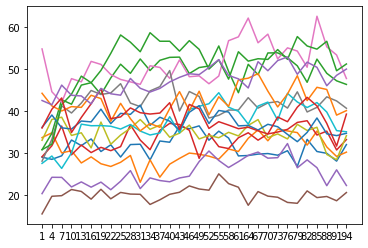

In [22]:
for num_ix, rand_num in enumerate(rand):
    for index_t_well, _ in tqdm.tqdm(enumerate(tot_well)):

        time_points = list(map(str, range(1,97,3)))

        new_time = []
        for i in time_points:
            r = '_' + i + '.'
            new_time.append(r)



        path_test = '/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T0_T97/{}_cropped/'.format(a)

        # NAME OF THE WELLS CORRESPONDING TO THE FRUG THAT YOU WANT IN THE TEST SET 

        wells_drug = [tot_well[index_t_well][0], tot_well[index_t_well][1]] 

        test = []

        for _,_, filenames in os.walk(path_test):

            for filename in sorted(filenames, key = natural_keys):

                for w in wells_drug:
                    for t in new_time:
                        if '{}'.format(w) in filename and '{}tiff'.format(t) in filename:
                            test.append(filename)

        groups_list = ['{}'.format(a), '{}'.format(b)]

        train = []

        validation = []

        group_compounds = []

        for group in tqdm.tqdm(groups_list):

            pa = '/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T0_T97/{}_cropped/'.format(group)

            for _,_, filenames in os.walk(pa):

                for filename in sorted(filenames, key = natural_keys):

                    for t in new_time:

                        if '_{}-'.format(wells_drug[0]) not in filename and '_{}-'.format(wells_drug[1]) not in filename and '{}tiff'.format(t) in filename:

                            group_compounds.append(filename)






        name =sorted(group_compounds)


        well = []
        for i in name:
            well.append(i.split('_id')[0])

        well_name = list(set(well))

        well_name = sorted(well_name)

        l = []
        for ix, _ in enumerate(well_name):
            n = []
            for i in name:
                if well_name[ix] in i:
                    n.append(i)
            l.append(n)


        tot_list = []

        for ix, i in tqdm.tqdm(enumerate(l)):


            id_n = []
            for j in l[ix]:
                id_n.append(j.split('_time')[0].split('_id_')[1])

            id_name = list(set(id_n))

            l1 = []
            for ixd, _ in enumerate(id_name):
                n1 = []
                for na in l[ix]:
                    if 'id_{}_time'.format(id_name[ixd]) in na:
                        n1.append(na)
                l1.append(n1)

            tot_list.append(l1)




        tra = []

        val = []

        for ie in tqdm.tqdm((range(len(tot_list)))):

            f_list = tot_list[ie]

            li = list(range((len(f_list))))

            f, s = train_test_split(li, test_size=0.2, random_state=rand_num)


            for i in f:

                tra.append(f_list[i])

            for v1 in s:
                val.append(f_list[v1])




        train = [i for sub in tra for i in sub]

        validation = [i for sub in val for i in sub]


        x_train = loadImages(train)
        y_train = make_labels(train)



        x_val = loadImages(validation)
        y_val = make_labels(validation)



        x_train = resize(x_train)


        x_val = resize(x_val)


        weights = class_weight.compute_class_weight('balanced', np.unique(y_train),y_train)


        x_train = preprocess_input(x_train)

        x_val = preprocess_input(x_val)


        es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=3)

        pretrained_model = VGG16(weights='imagenet',include_top=False, input_shape=(64, 64, 3))

        base_model = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('block3_pool').output)

        batch_size = 128

        datagen = ImageDataGenerator()

        datagen.fit(x_train)

        train_gen = datagen.flow(x_train, y_train,batch_size=batch_size )

        dat_val = ImageDataGenerator()

        dat_val.fit(x_val)

        val_gen = dat_val.flow(x_val, y_val,batch_size=batch_size)

        m4 = Sequential()
        m4.add(base_model)


        m4.add(BatchNormalization())
        m4.add(GlobalAveragePooling2D())
        m4.add(Dense(64, activation='relu'))
        m4.add(BatchNormalization())
        m4.add(Activation('relu'))
        m4.add(Dense(1,activation='sigmoid'))


        base_model.trainable = False

        opt = keras.optimizers.Adam(lr=1e-4)

        m4.compile(loss= keras.losses.binary_crossentropy, optimizer=opt, metrics = ['accuracy'])



        epochs = 300

        m4_h = m4.fit(train_gen,
                        steps_per_epoch=(len(x_train)/batch_size),
                        callbacks = [es],
                        epochs=epochs,
                        validation_data = (val_gen), 
                        validation_steps = (len(x_val)/batch_size),
                        class_weight = weights,
                         verbose = 1)

        base_model.trainable = True

        opt = keras.optimizers.Adam(lr=1e-5)

        m4.compile(loss= keras.losses.binary_crossentropy, optimizer=opt, metrics = ['accuracy'])

        epochs = 300

        m4_h = m4.fit(train_gen,
                        steps_per_epoch=(len(x_train)/batch_size),
                        callbacks = [es],
                        epochs=epochs,
                        validation_data = val_gen, 
                        validation_steps = (len(x_val)/batch_size),
                        class_weight = weights,
                        verbose = 1)

        l = []
        for t in new_time:
            for i in test:
                if t in i:
                    l.append((i))


        grouped = {}
        for elem in l:
            key = elem.split('.tiff')[0].split('_')[5]
            grouped.setdefault(key, []).append(elem)
        grouped = grouped.values()

        test_data = list(grouped)

        r = []

        for ix ,_ in enumerate(test_data):
            r.append(time_step_acc(test_data[ix],m4))

        plt.plot(time_points,r)
        plt.savefig('/home/jovyan/{}_accuracy.png'.format(string_well[index_t_well]))

        tot_results_accuracy.append(r)
        
        for i, layer in enumerate(m4.layers):
            layer._name = 'layer_' + str(i)



        lstm_model = Model(inputs=m4.input, outputs=m4.get_layer('layer_4').output)

        data_name = [train,test,validation]

        feat_name = ['train', 'test', 'validation']

        for index_name, _ in enumerate(data_name):

            path =  data_name[index_name]

            name_well = []

            for i in path:
                name_well.append(i.split('_id')[0])

            wells = list(set(name_well))
            wells

            for w in wells:

                time = []


                for filename in sorted(path, key = natural_keys):
                    if w in filename: #PAY ATTENTION ID THE IMAGE IS A TIFF OR PNG IMAGE #########
                        time.append(filename)

                data_id = {}
                n_id = []
                w_n = []

                for i in time:
                    t = i.split('_id_')[1].split('time_')[0]
                    f = i.split('_id_')[0].split('time_')[0]
                    n_id.append(t)
                    w_n.append(f)

                id_cell = set(n_id)


                for ix, i in enumerate(sorted(id_cell, key = natural_keys)):

                    id_name = []
                    dict_1 = {}

                    for t in time:
                        if 'id_{}'.format(i) in t:
                            id_name.append(t)

                    d = {'id':id_name}
                    data = pd.DataFrame(d)

                    dict_1[ix]=data 
                    data_id.update(dict_1) 

                delete = [i for i, j in data_id.items() if len(j) < 32] # 9 or the length of time span you are traning on 
                for i in delete : del data_id[i]

                len_id = [i for i, j in data_id.items()]

                for le in len_id:    


                    e = pd.DataFrame(data_id[le])

                    coords = e.values.tolist()
                    id_cells = []
                    for i in coords:
                        for j in i:
                            id_cells.append(j)

                    x_orig = loadImages(id_cells)
                    x_orig = resize(x_orig)

                    x_orig = preprocess_input(x_orig)
                    output = lstm_model.predict(x_orig)
                    np.save('/home/jovyan/DATA_MASTER_PROJECT/LSTM//FEAT_FOLDERS/features_{}/features_well_{}_id_{}.npy'.format(feat_name[index_name],w_n[0], le), output)
            print('Saved_feature_{}'.format(feat_name[index_name]))


        x_train_lstm = loadImages_LSTM(train_data)
        y_train_lstm = make_labels_LSTM(y_tra_path)

        x_test_lstm = loadImages_LSTM(tes_data)
        y_test_lstm = make_labels_LSTM(y_tes_path)

        x_val_lstm = loadImages_LSTM(val_data)
        y_val_lstm = make_labels_LSTM(y_val_path)

        weights_lstm = class_weight.compute_class_weight('balanced', np.unique(y_train_lstm),y_train_lstm)


        m = Sequential()
        m.add(LSTM(32, input_shape = (x_train_lstm.shape[1],x_train_lstm.shape[2])))
        m.add(Dropout(0.2))
        m.add(Dense(1, activation='sigmoid'))


        opt_lstm = keras.optimizers.Adam(lr=1e-4)

        m.compile(loss= keras.losses.binary_crossentropy, optimizer=opt, metrics = ['accuracy'])

        epochs = 300

        m_h = m.fit(x_train_lstm,y_train_lstm,

                         callbacks = [es],

                        epochs=epochs,
                        validation_data = (x_val_lstm,y_val_lstm), 

                        class_weight = weights_lstm)


        scores_lstm = m.evaluate(x_test_lstm, y_test_lstm)
        results_lstm.append([scores_lstm[1]*100, string_well[index_t_well]])

        # DELITE FILES IN FEATURE VECTOR FOLDERS

        folders = glob.glob('/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/*')

        for fo in folders:
            file = glob.glob(f'{fo}/*')
            for f in file:
                os.remove(f)

In [23]:
# ACCURACY SCORE AVERAGE FOR CNN
cv_s = cv_mean_acc(tot_results_accuracy, string_well)
cv_s

[(41.29738650905589, 'mid'),
 (47.145385264108576, 'leb'),
 (35.5723592142264, 'mep'),
 (29.52169361524284, 'met'),
 (36.669812677428126, 'oxy')]

In [24]:
# PLOT OF MEAN ACCURACY FOR EVERY TIME POINT CNN

l_drug = string_well*3

acc_plot = []

for i in tot_results_accuracy:
    acc_plot.append(i)

cv_plot = list(zip(acc_plot, l_drug))

res_plot = sorted(cv_plot, key = lambda x: x[1])

a , b = zip(*res_plot)
    
a = list(a)

s = list(np.array_split(a, 5))

cv_plot = []

for ix, i in enumerate(s):
    s1 = list(s[ix])
    
    cv_plot.append(np.average(s1, axis=0))

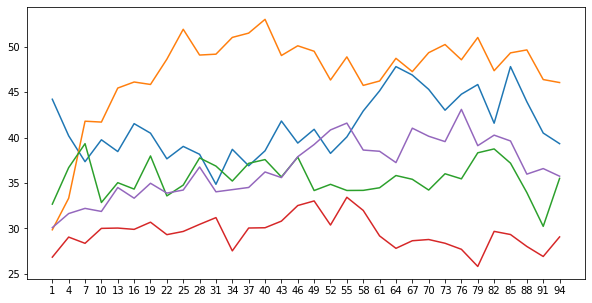

In [25]:
fig = plt.figure(figsize=(10, 5))
for i in cv_plot:
    
    plt.plot(time_points, i)
    plt.show
    plt.savefig('/home/jovyan/cv_score.png')

In [26]:
results_lstm = sorted(results_lstm, key=lambda x: x[1])
r_lstm , _ = zip(*results_lstm)
    
r_lstm = list(r_lstm)

re_lstm = list(np.array_split(r_lstm, 5))

cv_lstm = []

for ix, i in enumerate(re_lstm):
    r1 = list(re_lstm[ix])
    cv_lstm.append(np.mean(r1))


In [27]:
cv_lstm = list(zip(cv_lstm, string_well))
cv_lstm

[(23.35025320450465, 'mid'),
 (62.03288435935974, 'leb'),
 (34.01015202204386, 'mep'),
 (27.429274717966717, 'met'),
 (43.41085155804952, 'oxy')]

In [28]:
# BEFORE RUNNING AGAIN

folders = glob.glob('/home/jovyan/DATA_MASTER_PROJECT/LSTM/FEAT_FOLDERS/*')

for fo in folders:
    file = glob.glob(f'{fo}/*')
    for f in file:
        os.remove(f)